In [1]:
import cv2
import os
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Directories
elephant_dir = 'elephant'
non_elephant_dir = 'non_elephant'

X = []
y = []

def load_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            X.append(image)
            y.append(label)

# Load images
load_images_from_folder(elephant_dir, 1)  # Label 1 for elephants
load_images_from_folder(non_elephant_dir, 0)  # Label 0 for non-elephants

In [3]:
def preprocess_image(image):
    
    target_size = (128, 128)
    resized_image = cv2.resize(image, target_size)
    
    blurred = cv2.GaussianBlur(resized_image, (5, 5), 0)
    
    edges = cv2.Canny(blurred, 100, 200)
    
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    linked_edges = np.zeros_like(edges)
    cv2.drawContours(linked_edges, contours, -1, (255, 255, 255), 1)
    
    return linked_edges

processed_images = [preprocess_image(image) for image in X]

In [4]:
def extract_hog_features(image):
    # Extract HOG features
    hog_feature, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, feature_vector=True)
    return hog_feature

hog_features = [extract_hog_features(image) for image in processed_images]


In [5]:
hog_features = np.array(hog_features)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(hog_features, y, test_size=0.2, random_state=42)

svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Classification Accuracy: {accuracy * 100:.2f}%')


Classification Accuracy: 83.27%


In [6]:
def classify_image(image_path, classifier, target_size=(128, 128)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None, None
    processed_image = preprocess_image(image)
    
    #HOG features
    hog_feature = extract_hog_features(processed_image)
    hog_feature = hog_feature.reshape(1, -1)
    
    prediction = classifier.predict(hog_feature)
    probability = classifier.predict_proba(hog_feature)
    
    return prediction[0], probability[0]   

The image does not contain an elephant with a probability of 0.79.


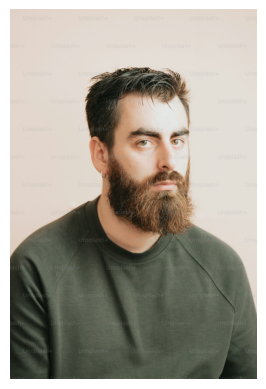

In [7]:
image_path = 'image_2.jpg'
label, prob = classify_image(image_path, svm)
if label == 1:
    print(f'The image contains an elephant with a probability of {prob[1]:.2f}.')
else:
    print(f'The image does not contain an elephant with a probability of {prob[0]:.2f}.')

image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


The image contains an elephant with a probability of 0.97.


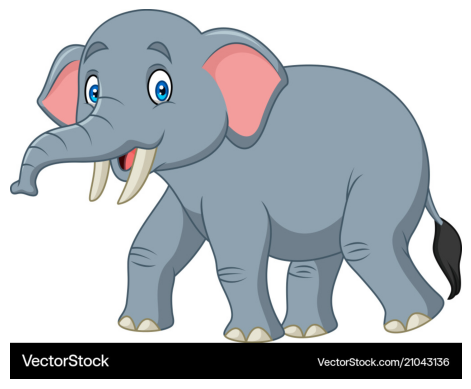

In [8]:
image_path = 'image.jpg'
label, prob = classify_image(image_path, svm)
if label == 1:
    print(f'The image contains an elephant with a probability of {prob[1]:.2f}.')
else:
    print(f'The image does not contain an elephant with a probability of {prob[0]:.2f}.')

image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


Summary of Choices
Canny Edge Detection: Chosen for its ability to detect clear, precise edges with minimal noise compared to Sobel. Canny’s multi-stage process improves edge accuracy and robustness.

Edge Linking: Used to connect fragmented edges from Canny detection into continuous boundaries, enhancing edge maps for better feature extraction.

HOG Features: Selected for its effectiveness in capturing shape and structure by analyzing gradient orientations, making it robust against lighting changes and effective for object recognition.

SVM Classifier: Chosen for its strong performance in high-dimensional spaces and its ability to find the optimal decision boundary, making it well-suited for classification tasks with HOG features.